In [1]:
#importing all packages
import matplotlib.pyplot as plt
import numpy as np
# Import PyTorch libraries
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')
print("Libraries imported - ready to use PyTorch", torch.__version__)


Libraries imported - ready to use PyTorch 1.7.1


In [2]:
#Loading training and testing data as .npy files#Datasets are here in'.npy'format after being scaled individually based on their 
#individual maximum amplitude

def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample


train_set = torchvision.datasets.DatasetFolder(root='./data/wholedata/without_noise/gamma_proton/train_set/',
                                               loader=npy_loader, 
                                               extensions='.npy', transform=None)

trainloader = torch.utils.data.DataLoader(train_set, batch_size=10,
                                         shuffle=True, num_workers=2)

test_set = torchvision.datasets.DatasetFolder(root='./data/wholedata/without_noise/gamma_proton/test_set/',
                                              loader=npy_loader, 
                                               extensions='.npy', transform=None)

testloader = torch.utils.data.DataLoader(test_set, batch_size=1,
                                         shuffle=False, num_workers=2)

classes = ('gamma', 'proton')
print(classes)
print(len(train_set))
print(len(test_set))

('gamma', 'proton')
16120
4680


torch.Size([10, 52, 52])
torch.Size([52, 52])
1.0


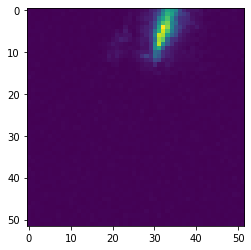

proton


In [3]:
##functions to show an image
def imshow(img):
    npimg = img.numpy()
    print(img.size())
    print(img[0].size())
    plt.imshow(npimg[0])
    print(np.max(npimg))
    plt.show()


##get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

##show images
imshow(torchvision.utils.make_grid(images))

##print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(1)))


In [4]:
#crosschecking the size using the chosen dimensions before defining the convolutional 
#layers:#Use the equation ((W-F+2P)S)+1 check if the size of the output layesrs are correct!
images=images.view(-1,1,52,52)
print(images.shape)
conv1=nn.Conv2d(1,10,5)
#pool=nn.MaxPool2d(2,2)
pool=nn.AvgPool2d(2,2)
conv2=nn.Conv2d(10,4,3)
x=conv1(images)
print(x.shape)
x=pool(x)
print(x.shape)
x=conv2(x)
print(x.shape)
x=pool(x)
print(x.shape)

torch.Size([10, 1, 52, 52])
torch.Size([10, 10, 48, 48])
torch.Size([10, 10, 24, 24])
torch.Size([10, 4, 22, 22])
torch.Size([10, 4, 11, 11])


In [5]:
#Define a Convolutional Neural Network(For  1-channel images)

class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1=nn.Conv2d(1,10,5)
        #self.pool=nn.MaxPool2d(2,2)
        self.pool=nn.AvgPool2d(2,2)
        self.conv2=nn.Conv2d(10,4,3)
        self.fc1=nn.Linear(4*11*11,80)
        self.fc2=nn.Linear(80,1)
        
        # Define proportion or neurons to dropout
        #self.dropout = nn.Dropout(0.0037)
        
    def forward(self, x):
        x=x.view(-1,1,52,52)
        
        # Apply dropout
        #x = self.dropout(x)
        
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,4*11*11)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
net=Net()

In [6]:
##Define a Loss function and optimizer:#Loss function:Binary Cross-Entropy loss,
##optimizer: Adam#BCE_loss function needs the usage of Sigmoid activation function to be given for the
##binary classification

m = nn.Sigmoid()
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [7]:
##Train the network
# loop over our data iterator, and feed the inputs to the network and optimize

for epoch in range(80):# loop over the dataset multiple times
    running_loss = 0.0
    correct = 0
    for i, data in enumerate(trainloader, 0):
        
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        
        labels = torch.tensor(labels, dtype = torch.float)
        #print(labels.shape)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        outputs = net(inputs)
        #print((m(outputs)).shape)
        #print(labels.shape)
        
        #use the sigmoid function(m) before calculation the gradient of loss function
        loss = criterion(m(outputs.squeeze()), labels)
        loss.backward()
        optimizer.step()
        
        # print statistics:
        # print every 10 mini-batches
        running_loss += loss.item()
        outputs = (outputs.squeeze()>0.5).float()
        correct += (outputs == labels).float().sum()
        if i % 10 == 9:                                                           
            print('[%d,%5d] loss:%.3f'% (epoch+1, i+1, running_loss/10))
            running_loss=0.0
    accuracy = 100*correct/(len(inputs)*len(trainloader))
    print('[Epoch: %d], loss:%.3f, Acc.:%.2f'% (epoch+1, running_loss/10, accuracy))
            
print('Finished Training')
        

/tmp/ipykernel_184301/373628640.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype = torch.float)


[1,   10] loss:0.694
[1,   20] loss:0.693
[1,   30] loss:0.692
[1,   40] loss:0.691
[1,   50] loss:0.691
[1,   60] loss:0.683
[1,   70] loss:0.671
[1,   80] loss:0.687
[1,   90] loss:0.674
[1,  100] loss:0.679
[1,  110] loss:0.708
[1,  120] loss:0.688
[1,  130] loss:0.685
[1,  140] loss:0.684
[1,  150] loss:0.681
[1,  160] loss:0.671
[1,  170] loss:0.696
[1,  180] loss:0.682
[1,  190] loss:0.682
[1,  200] loss:0.694
[1,  210] loss:0.680
[1,  220] loss:0.690
[1,  230] loss:0.680
[1,  240] loss:0.689
[1,  250] loss:0.691
[1,  260] loss:0.690
[1,  270] loss:0.677
[1,  280] loss:0.674
[1,  290] loss:0.739
[1,  300] loss:0.679
[1,  310] loss:0.679
[1,  320] loss:0.690
[1,  330] loss:0.698
[1,  340] loss:0.680
[1,  350] loss:0.692
[1,  360] loss:0.675
[1,  370] loss:0.708
[1,  380] loss:0.694
[1,  390] loss:0.685
[1,  400] loss:0.698
[1,  410] loss:0.686
[1,  420] loss:0.690
[1,  430] loss:0.691
[1,  440] loss:0.680
[1,  450] loss:0.677
[1,  460] loss:0.679
[1,  470] loss:0.704
[1,  480] los

[3,  660] loss:0.689
[3,  670] loss:0.675
[3,  680] loss:0.673
[3,  690] loss:0.638
[3,  700] loss:0.660
[3,  710] loss:0.693
[3,  720] loss:0.675
[3,  730] loss:0.652
[3,  740] loss:0.659
[3,  750] loss:0.696
[3,  760] loss:0.672
[3,  770] loss:0.654
[3,  780] loss:0.665
[3,  790] loss:0.625
[3,  800] loss:0.640
[3,  810] loss:0.676
[3,  820] loss:0.648
[3,  830] loss:0.650
[3,  840] loss:0.650
[3,  850] loss:0.613
[3,  860] loss:0.668
[3,  870] loss:0.672
[3,  880] loss:0.628
[3,  890] loss:0.677
[3,  900] loss:0.682
[3,  910] loss:0.648
[3,  920] loss:0.668
[3,  930] loss:0.635
[3,  940] loss:0.641
[3,  950] loss:0.649
[3,  960] loss:0.637
[3,  970] loss:0.659
[3,  980] loss:0.644
[3,  990] loss:0.654
[3, 1000] loss:0.613
[3, 1010] loss:0.694
[3, 1020] loss:0.655
[3, 1030] loss:0.639
[3, 1040] loss:0.622
[3, 1050] loss:0.654
[3, 1060] loss:0.714
[3, 1070] loss:0.629
[3, 1080] loss:0.651
[3, 1090] loss:0.636
[3, 1100] loss:0.631
[3, 1110] loss:0.660
[3, 1120] loss:0.650
[3, 1130] los

[5, 1310] loss:0.576
[5, 1320] loss:0.588
[5, 1330] loss:0.570
[5, 1340] loss:0.577
[5, 1350] loss:0.596
[5, 1360] loss:0.636
[5, 1370] loss:0.649
[5, 1380] loss:0.584
[5, 1390] loss:0.523
[5, 1400] loss:0.583
[5, 1410] loss:0.520
[5, 1420] loss:0.603
[5, 1430] loss:0.619
[5, 1440] loss:0.596
[5, 1450] loss:0.583
[5, 1460] loss:0.572
[5, 1470] loss:0.573
[5, 1480] loss:0.467
[5, 1490] loss:0.590
[5, 1500] loss:0.638
[5, 1510] loss:0.541
[5, 1520] loss:0.604
[5, 1530] loss:0.773
[5, 1540] loss:0.638
[5, 1550] loss:0.610
[5, 1560] loss:0.634
[5, 1570] loss:0.647
[5, 1580] loss:0.585
[5, 1590] loss:0.618
[5, 1600] loss:0.582
[5, 1610] loss:0.632
[Epoch: 5], loss:0.130, Acc.:60.20
[6,   10] loss:0.607
[6,   20] loss:0.587
[6,   30] loss:0.547
[6,   40] loss:0.626
[6,   50] loss:0.580
[6,   60] loss:0.627
[6,   70] loss:0.598
[6,   80] loss:0.557
[6,   90] loss:0.591
[6,  100] loss:0.630
[6,  110] loss:0.525
[6,  120] loss:0.560
[6,  130] loss:0.639
[6,  140] loss:0.623
[6,  150] loss:0.631

[8,  350] loss:0.533
[8,  360] loss:0.532
[8,  370] loss:0.541
[8,  380] loss:0.607
[8,  390] loss:0.563
[8,  400] loss:0.504
[8,  410] loss:0.506
[8,  420] loss:0.452
[8,  430] loss:0.565
[8,  440] loss:0.592
[8,  450] loss:0.664
[8,  460] loss:0.545
[8,  470] loss:0.545
[8,  480] loss:0.520
[8,  490] loss:0.573
[8,  500] loss:0.577
[8,  510] loss:0.527
[8,  520] loss:0.548
[8,  530] loss:0.514
[8,  540] loss:0.513
[8,  550] loss:0.595
[8,  560] loss:0.557
[8,  570] loss:0.563
[8,  580] loss:0.517
[8,  590] loss:0.523
[8,  600] loss:0.573
[8,  610] loss:0.428
[8,  620] loss:0.553
[8,  630] loss:0.578
[8,  640] loss:0.512
[8,  650] loss:0.523
[8,  660] loss:0.546
[8,  670] loss:0.514
[8,  680] loss:0.548
[8,  690] loss:0.458
[8,  700] loss:0.466
[8,  710] loss:0.554
[8,  720] loss:0.464
[8,  730] loss:0.585
[8,  740] loss:0.619
[8,  750] loss:0.520
[8,  760] loss:0.489
[8,  770] loss:0.558
[8,  780] loss:0.502
[8,  790] loss:0.521
[8,  800] loss:0.602
[8,  810] loss:0.458
[8,  820] los

[10,  980] loss:0.557
[10,  990] loss:0.466
[10, 1000] loss:0.547
[10, 1010] loss:0.511
[10, 1020] loss:0.494
[10, 1030] loss:0.483
[10, 1040] loss:0.445
[10, 1050] loss:0.519
[10, 1060] loss:0.486
[10, 1070] loss:0.499
[10, 1080] loss:0.428
[10, 1090] loss:0.433
[10, 1100] loss:0.454
[10, 1110] loss:0.391
[10, 1120] loss:0.450
[10, 1130] loss:0.456
[10, 1140] loss:0.387
[10, 1150] loss:0.558
[10, 1160] loss:0.467
[10, 1170] loss:0.566
[10, 1180] loss:0.442
[10, 1190] loss:0.497
[10, 1200] loss:0.546
[10, 1210] loss:0.477
[10, 1220] loss:0.466
[10, 1230] loss:0.534
[10, 1240] loss:0.412
[10, 1250] loss:0.604
[10, 1260] loss:0.582
[10, 1270] loss:0.514
[10, 1280] loss:0.516
[10, 1290] loss:0.587
[10, 1300] loss:0.433
[10, 1310] loss:0.446
[10, 1320] loss:0.472
[10, 1330] loss:0.461
[10, 1340] loss:0.464
[10, 1350] loss:0.550
[10, 1360] loss:0.472
[10, 1370] loss:0.453
[10, 1380] loss:0.527
[10, 1390] loss:0.430
[10, 1400] loss:0.552
[10, 1410] loss:0.475
[10, 1420] loss:0.439
[10, 1430]

[12, 1470] loss:0.438
[12, 1480] loss:0.433
[12, 1490] loss:0.433
[12, 1500] loss:0.436
[12, 1510] loss:0.345
[12, 1520] loss:0.418
[12, 1530] loss:0.451
[12, 1540] loss:0.435
[12, 1550] loss:0.461
[12, 1560] loss:0.457
[12, 1570] loss:0.408
[12, 1580] loss:0.386
[12, 1590] loss:0.417
[12, 1600] loss:0.383
[12, 1610] loss:0.481
[Epoch: 12], loss:0.087, Acc.:75.73
[13,   10] loss:0.510
[13,   20] loss:0.526
[13,   30] loss:0.500
[13,   40] loss:0.424
[13,   50] loss:0.405
[13,   60] loss:0.458
[13,   70] loss:0.446
[13,   80] loss:0.392
[13,   90] loss:0.373
[13,  100] loss:0.538
[13,  110] loss:0.439
[13,  120] loss:0.371
[13,  130] loss:0.491
[13,  140] loss:0.492
[13,  150] loss:0.433
[13,  160] loss:0.389
[13,  170] loss:0.444
[13,  180] loss:0.448
[13,  190] loss:0.372
[13,  200] loss:0.321
[13,  210] loss:0.412
[13,  220] loss:0.450
[13,  230] loss:0.489
[13,  240] loss:0.422
[13,  250] loss:0.424
[13,  260] loss:0.483
[13,  270] loss:0.506
[13,  280] loss:0.497
[13,  290] loss:0.

[15,  330] loss:0.395
[15,  340] loss:0.389
[15,  350] loss:0.389
[15,  360] loss:0.377
[15,  370] loss:0.383
[15,  380] loss:0.476
[15,  390] loss:0.401
[15,  400] loss:0.500
[15,  410] loss:0.444
[15,  420] loss:0.465
[15,  430] loss:0.417
[15,  440] loss:0.422
[15,  450] loss:0.385
[15,  460] loss:0.346
[15,  470] loss:0.379
[15,  480] loss:0.573
[15,  490] loss:0.410
[15,  500] loss:0.361
[15,  510] loss:0.346
[15,  520] loss:0.368
[15,  530] loss:0.372
[15,  540] loss:0.342
[15,  550] loss:0.478
[15,  560] loss:0.339
[15,  570] loss:0.342
[15,  580] loss:0.408
[15,  590] loss:0.340
[15,  600] loss:0.440
[15,  610] loss:0.405
[15,  620] loss:0.400
[15,  630] loss:0.396
[15,  640] loss:0.386
[15,  650] loss:0.404
[15,  660] loss:0.405
[15,  670] loss:0.402
[15,  680] loss:0.439
[15,  690] loss:0.387
[15,  700] loss:0.408
[15,  710] loss:0.445
[15,  720] loss:0.471
[15,  730] loss:0.366
[15,  740] loss:0.459
[15,  750] loss:0.413
[15,  760] loss:0.468
[15,  770] loss:0.493
[15,  780]

[17,  820] loss:0.338
[17,  830] loss:0.393
[17,  840] loss:0.432
[17,  850] loss:0.440
[17,  860] loss:0.380
[17,  870] loss:0.335
[17,  880] loss:0.366
[17,  890] loss:0.374
[17,  900] loss:0.365
[17,  910] loss:0.497
[17,  920] loss:0.386
[17,  930] loss:0.426
[17,  940] loss:0.331
[17,  950] loss:0.405
[17,  960] loss:0.391
[17,  970] loss:0.439
[17,  980] loss:0.302
[17,  990] loss:0.376
[17, 1000] loss:0.361
[17, 1010] loss:0.486
[17, 1020] loss:0.389
[17, 1030] loss:0.348
[17, 1040] loss:0.516
[17, 1050] loss:0.367
[17, 1060] loss:0.375
[17, 1070] loss:0.369
[17, 1080] loss:0.370
[17, 1090] loss:0.378
[17, 1100] loss:0.398
[17, 1110] loss:0.360
[17, 1120] loss:0.467
[17, 1130] loss:0.328
[17, 1140] loss:0.388
[17, 1150] loss:0.328
[17, 1160] loss:0.400
[17, 1170] loss:0.366
[17, 1180] loss:0.330
[17, 1190] loss:0.347
[17, 1200] loss:0.379
[17, 1210] loss:0.373
[17, 1220] loss:0.378
[17, 1230] loss:0.353
[17, 1240] loss:0.398
[17, 1250] loss:0.463
[17, 1260] loss:0.390
[17, 1270]

[19, 1300] loss:0.367
[19, 1310] loss:0.305
[19, 1320] loss:0.329
[19, 1330] loss:0.440
[19, 1340] loss:0.375
[19, 1350] loss:0.402
[19, 1360] loss:0.332
[19, 1370] loss:0.419
[19, 1380] loss:0.298
[19, 1390] loss:0.309
[19, 1400] loss:0.354
[19, 1410] loss:0.422
[19, 1420] loss:0.302
[19, 1430] loss:0.338
[19, 1440] loss:0.335
[19, 1450] loss:0.367
[19, 1460] loss:0.342
[19, 1470] loss:0.359
[19, 1480] loss:0.215
[19, 1490] loss:0.357
[19, 1500] loss:0.362
[19, 1510] loss:0.335
[19, 1520] loss:0.350
[19, 1530] loss:0.439
[19, 1540] loss:0.346
[19, 1550] loss:0.363
[19, 1560] loss:0.466
[19, 1570] loss:0.389
[19, 1580] loss:0.289
[19, 1590] loss:0.446
[19, 1600] loss:0.403
[19, 1610] loss:0.279
[Epoch: 19], loss:0.046, Acc.:80.67
[20,   10] loss:0.319
[20,   20] loss:0.370
[20,   30] loss:0.364
[20,   40] loss:0.412
[20,   50] loss:0.361
[20,   60] loss:0.403
[20,   70] loss:0.316
[20,   80] loss:0.334
[20,   90] loss:0.344
[20,  100] loss:0.266
[20,  110] loss:0.237
[20,  120] loss:0.

[22,  150] loss:0.397
[22,  160] loss:0.414
[22,  170] loss:0.283
[22,  180] loss:0.395
[22,  190] loss:0.366
[22,  200] loss:0.284
[22,  210] loss:0.277
[22,  220] loss:0.420
[22,  230] loss:0.313
[22,  240] loss:0.307
[22,  250] loss:0.354
[22,  260] loss:0.363
[22,  270] loss:0.393
[22,  280] loss:0.360
[22,  290] loss:0.332
[22,  300] loss:0.399
[22,  310] loss:0.380
[22,  320] loss:0.301
[22,  330] loss:0.292
[22,  340] loss:0.359
[22,  350] loss:0.375
[22,  360] loss:0.341
[22,  370] loss:0.299
[22,  380] loss:0.285
[22,  390] loss:0.443
[22,  400] loss:0.397
[22,  410] loss:0.458
[22,  420] loss:0.389
[22,  430] loss:0.337
[22,  440] loss:0.342
[22,  450] loss:0.349
[22,  460] loss:0.353
[22,  470] loss:0.320
[22,  480] loss:0.343
[22,  490] loss:0.373
[22,  500] loss:0.296
[22,  510] loss:0.294
[22,  520] loss:0.374
[22,  530] loss:0.435
[22,  540] loss:0.283
[22,  550] loss:0.311
[22,  560] loss:0.346
[22,  570] loss:0.356
[22,  580] loss:0.385
[22,  590] loss:0.314
[22,  600]

[24,  640] loss:0.372
[24,  650] loss:0.398
[24,  660] loss:0.363
[24,  670] loss:0.337
[24,  680] loss:0.273
[24,  690] loss:0.323
[24,  700] loss:0.294
[24,  710] loss:0.361
[24,  720] loss:0.287
[24,  730] loss:0.242
[24,  740] loss:0.377
[24,  750] loss:0.381
[24,  760] loss:0.376
[24,  770] loss:0.352
[24,  780] loss:0.315
[24,  790] loss:0.304
[24,  800] loss:0.319
[24,  810] loss:0.512
[24,  820] loss:0.396
[24,  830] loss:0.339
[24,  840] loss:0.328
[24,  850] loss:0.260
[24,  860] loss:0.317
[24,  870] loss:0.354
[24,  880] loss:0.253
[24,  890] loss:0.315
[24,  900] loss:0.334
[24,  910] loss:0.274
[24,  920] loss:0.310
[24,  930] loss:0.333
[24,  940] loss:0.373
[24,  950] loss:0.381
[24,  960] loss:0.442
[24,  970] loss:0.362
[24,  980] loss:0.423
[24,  990] loss:0.434
[24, 1000] loss:0.558
[24, 1010] loss:0.420
[24, 1020] loss:0.363
[24, 1030] loss:0.367
[24, 1040] loss:0.363
[24, 1050] loss:0.326
[24, 1060] loss:0.286
[24, 1070] loss:0.407
[24, 1080] loss:0.482
[24, 1090]

[26, 1120] loss:0.261
[26, 1130] loss:0.330
[26, 1140] loss:0.279
[26, 1150] loss:0.310
[26, 1160] loss:0.356
[26, 1170] loss:0.458
[26, 1180] loss:1.414
[26, 1190] loss:0.638
[26, 1200] loss:0.447
[26, 1210] loss:0.349
[26, 1220] loss:0.372
[26, 1230] loss:0.300
[26, 1240] loss:0.321
[26, 1250] loss:0.377
[26, 1260] loss:0.354
[26, 1270] loss:0.406
[26, 1280] loss:0.327
[26, 1290] loss:0.309
[26, 1300] loss:0.426
[26, 1310] loss:0.318
[26, 1320] loss:0.357
[26, 1330] loss:0.261
[26, 1340] loss:0.266
[26, 1350] loss:0.254
[26, 1360] loss:0.201
[26, 1370] loss:0.260
[26, 1380] loss:0.271
[26, 1390] loss:0.345
[26, 1400] loss:0.333
[26, 1410] loss:0.337
[26, 1420] loss:0.442
[26, 1430] loss:0.340
[26, 1440] loss:0.315
[26, 1450] loss:0.308
[26, 1460] loss:0.308
[26, 1470] loss:0.403
[26, 1480] loss:0.345
[26, 1490] loss:0.245
[26, 1500] loss:0.318
[26, 1510] loss:0.241
[26, 1520] loss:0.307
[26, 1530] loss:0.283
[26, 1540] loss:0.366
[26, 1550] loss:0.457
[26, 1560] loss:0.358
[26, 1570]

[28, 1610] loss:0.330
[Epoch: 28], loss:0.111, Acc.:84.86
[29,   10] loss:0.236
[29,   20] loss:0.431
[29,   30] loss:0.306
[29,   40] loss:0.279
[29,   50] loss:0.296
[29,   60] loss:0.347
[29,   70] loss:0.231
[29,   80] loss:0.290
[29,   90] loss:0.281
[29,  100] loss:0.328
[29,  110] loss:0.357
[29,  120] loss:0.419
[29,  130] loss:0.353
[29,  140] loss:0.297
[29,  150] loss:0.330
[29,  160] loss:0.301
[29,  170] loss:0.230
[29,  180] loss:0.481
[29,  190] loss:0.444
[29,  200] loss:0.386
[29,  210] loss:0.364
[29,  220] loss:0.235
[29,  230] loss:0.217
[29,  240] loss:0.296
[29,  250] loss:0.294
[29,  260] loss:0.255
[29,  270] loss:0.389
[29,  280] loss:0.392
[29,  290] loss:0.270
[29,  300] loss:0.332
[29,  310] loss:0.307
[29,  320] loss:0.299
[29,  330] loss:0.348
[29,  340] loss:0.310
[29,  350] loss:0.269
[29,  360] loss:0.290
[29,  370] loss:0.304
[29,  380] loss:0.405
[29,  390] loss:0.347
[29,  400] loss:0.259
[29,  410] loss:0.327
[29,  420] loss:0.411
[29,  430] loss:0.

[31,  460] loss:0.280
[31,  470] loss:0.266
[31,  480] loss:0.233
[31,  490] loss:0.291
[31,  500] loss:0.371
[31,  510] loss:0.348
[31,  520] loss:0.343
[31,  530] loss:0.303
[31,  540] loss:0.269
[31,  550] loss:0.311
[31,  560] loss:0.292
[31,  570] loss:0.320
[31,  580] loss:0.347
[31,  590] loss:0.374
[31,  600] loss:0.234
[31,  610] loss:0.301
[31,  620] loss:0.443
[31,  630] loss:0.233
[31,  640] loss:0.230
[31,  650] loss:0.342
[31,  660] loss:0.288
[31,  670] loss:0.290
[31,  680] loss:0.329
[31,  690] loss:0.322
[31,  700] loss:0.396
[31,  710] loss:0.326
[31,  720] loss:0.247
[31,  730] loss:0.326
[31,  740] loss:0.403
[31,  750] loss:0.257
[31,  760] loss:0.375
[31,  770] loss:0.301
[31,  780] loss:0.381
[31,  790] loss:0.405
[31,  800] loss:0.424
[31,  810] loss:0.465
[31,  820] loss:0.650
[31,  830] loss:0.387
[31,  840] loss:0.362
[31,  850] loss:0.405
[31,  860] loss:0.559
[31,  870] loss:0.546
[31,  880] loss:0.436
[31,  890] loss:0.361
[31,  900] loss:0.482
[31,  910]

[33,  960] loss:0.292
[33,  970] loss:0.283
[33,  980] loss:0.258
[33,  990] loss:0.274
[33, 1000] loss:0.235
[33, 1010] loss:0.215
[33, 1020] loss:0.251
[33, 1030] loss:0.476
[33, 1040] loss:0.383
[33, 1050] loss:0.295
[33, 1060] loss:0.327
[33, 1070] loss:0.178
[33, 1080] loss:0.317
[33, 1090] loss:0.293
[33, 1100] loss:0.238
[33, 1110] loss:0.239
[33, 1120] loss:0.319
[33, 1130] loss:0.257
[33, 1140] loss:0.358
[33, 1150] loss:0.298
[33, 1160] loss:0.335
[33, 1170] loss:0.285
[33, 1180] loss:0.293
[33, 1190] loss:0.308
[33, 1200] loss:0.261
[33, 1210] loss:0.254
[33, 1220] loss:0.329
[33, 1230] loss:0.344
[33, 1240] loss:0.257
[33, 1250] loss:0.302
[33, 1260] loss:0.273
[33, 1270] loss:0.402
[33, 1280] loss:0.355
[33, 1290] loss:0.271
[33, 1300] loss:0.276
[33, 1310] loss:0.345
[33, 1320] loss:0.348
[33, 1330] loss:0.287
[33, 1340] loss:0.326
[33, 1350] loss:0.274
[33, 1360] loss:0.320
[33, 1370] loss:0.270
[33, 1380] loss:0.269
[33, 1390] loss:0.279
[33, 1400] loss:0.341
[33, 1410]

[35, 1450] loss:0.354
[35, 1460] loss:0.501
[35, 1470] loss:0.418
[35, 1480] loss:0.363
[35, 1490] loss:0.437
[35, 1500] loss:0.530
[35, 1510] loss:0.421
[35, 1520] loss:0.339
[35, 1530] loss:0.388
[35, 1540] loss:0.308
[35, 1550] loss:0.314
[35, 1560] loss:0.311
[35, 1570] loss:0.388
[35, 1580] loss:0.385
[35, 1590] loss:0.401
[35, 1600] loss:0.382
[35, 1610] loss:0.379
[Epoch: 35], loss:0.060, Acc.:84.28
[36,   10] loss:0.647
[36,   20] loss:0.447
[36,   30] loss:0.402
[36,   40] loss:0.427
[36,   50] loss:0.389
[36,   60] loss:0.422
[36,   70] loss:0.326
[36,   80] loss:0.472
[36,   90] loss:1.476
[36,  100] loss:0.389
[36,  110] loss:0.358
[36,  120] loss:0.433
[36,  130] loss:0.419
[36,  140] loss:0.467
[36,  150] loss:0.357
[36,  160] loss:0.437
[36,  170] loss:0.331
[36,  180] loss:0.329
[36,  190] loss:0.452
[36,  200] loss:0.424
[36,  210] loss:0.417
[36,  220] loss:0.379
[36,  230] loss:0.452
[36,  240] loss:0.381
[36,  250] loss:0.432
[36,  260] loss:0.397
[36,  270] loss:0.

[38,  310] loss:0.277
[38,  320] loss:0.242
[38,  330] loss:0.278
[38,  340] loss:0.266
[38,  350] loss:0.280
[38,  360] loss:0.245
[38,  370] loss:0.251
[38,  380] loss:0.289
[38,  390] loss:0.229
[38,  400] loss:0.305
[38,  410] loss:0.293
[38,  420] loss:0.289
[38,  430] loss:0.260
[38,  440] loss:0.299
[38,  450] loss:0.272
[38,  460] loss:0.283
[38,  470] loss:0.263
[38,  480] loss:0.279
[38,  490] loss:0.234
[38,  500] loss:0.285
[38,  510] loss:0.178
[38,  520] loss:0.239
[38,  530] loss:0.349
[38,  540] loss:0.385
[38,  550] loss:0.314
[38,  560] loss:0.410
[38,  570] loss:0.441
[38,  580] loss:0.384
[38,  590] loss:0.451
[38,  600] loss:0.353
[38,  610] loss:0.453
[38,  620] loss:0.313
[38,  630] loss:0.315
[38,  640] loss:0.270
[38,  650] loss:0.362
[38,  660] loss:0.316
[38,  670] loss:0.253
[38,  680] loss:0.282
[38,  690] loss:0.408
[38,  700] loss:0.235
[38,  710] loss:0.488
[38,  720] loss:0.277
[38,  730] loss:0.295
[38,  740] loss:0.313
[38,  750] loss:0.337
[38,  760]

[40,  790] loss:0.276
[40,  800] loss:0.290
[40,  810] loss:0.269
[40,  820] loss:0.297
[40,  830] loss:0.455
[40,  840] loss:0.353
[40,  850] loss:0.332
[40,  860] loss:0.274
[40,  870] loss:0.237
[40,  880] loss:0.237
[40,  890] loss:0.246
[40,  900] loss:0.261
[40,  910] loss:0.403
[40,  920] loss:0.189
[40,  930] loss:0.178
[40,  940] loss:0.225
[40,  950] loss:0.313
[40,  960] loss:0.279
[40,  970] loss:0.283
[40,  980] loss:0.279
[40,  990] loss:0.268
[40, 1000] loss:0.305
[40, 1010] loss:0.240
[40, 1020] loss:0.235
[40, 1030] loss:0.322
[40, 1040] loss:0.285
[40, 1050] loss:0.220
[40, 1060] loss:0.300
[40, 1070] loss:0.298
[40, 1080] loss:0.263
[40, 1090] loss:0.310
[40, 1100] loss:0.356
[40, 1110] loss:0.294
[40, 1120] loss:0.258
[40, 1130] loss:0.255
[40, 1140] loss:0.264
[40, 1150] loss:0.210
[40, 1160] loss:0.239
[40, 1170] loss:0.210
[40, 1180] loss:0.273
[40, 1190] loss:0.343
[40, 1200] loss:0.189
[40, 1210] loss:0.219
[40, 1220] loss:0.318
[40, 1230] loss:0.352
[40, 1240]

[42, 1270] loss:0.282
[42, 1280] loss:0.198
[42, 1290] loss:0.223
[42, 1300] loss:0.310
[42, 1310] loss:0.345
[42, 1320] loss:0.295
[42, 1330] loss:0.311
[42, 1340] loss:0.287
[42, 1350] loss:0.215
[42, 1360] loss:0.241
[42, 1370] loss:0.303
[42, 1380] loss:0.266
[42, 1390] loss:0.195
[42, 1400] loss:0.219
[42, 1410] loss:0.210
[42, 1420] loss:0.253
[42, 1430] loss:0.302
[42, 1440] loss:0.216
[42, 1450] loss:0.304
[42, 1460] loss:0.199
[42, 1470] loss:0.253
[42, 1480] loss:0.269
[42, 1490] loss:0.202
[42, 1500] loss:0.401
[42, 1510] loss:0.233
[42, 1520] loss:0.329
[42, 1530] loss:0.251
[42, 1540] loss:0.193
[42, 1550] loss:0.313
[42, 1560] loss:0.284
[42, 1570] loss:0.238
[42, 1580] loss:0.226
[42, 1590] loss:0.268
[42, 1600] loss:0.301
[42, 1610] loss:0.310
[Epoch: 42], loss:0.050, Acc.:85.06
[43,   10] loss:0.184
[43,   20] loss:0.381
[43,   30] loss:0.308
[43,   40] loss:0.307
[43,   50] loss:0.331
[43,   60] loss:0.332
[43,   70] loss:0.234
[43,   80] loss:0.292
[43,   90] loss:0.

[45,  130] loss:0.276
[45,  140] loss:0.300
[45,  150] loss:0.283
[45,  160] loss:0.210
[45,  170] loss:0.264
[45,  180] loss:0.282
[45,  190] loss:0.202
[45,  200] loss:0.269
[45,  210] loss:0.287
[45,  220] loss:0.225
[45,  230] loss:0.245
[45,  240] loss:0.300
[45,  250] loss:0.349
[45,  260] loss:0.302
[45,  270] loss:0.215
[45,  280] loss:0.257
[45,  290] loss:0.235
[45,  300] loss:0.283
[45,  310] loss:0.261
[45,  320] loss:0.255
[45,  330] loss:0.259
[45,  340] loss:0.322
[45,  350] loss:0.268
[45,  360] loss:0.223
[45,  370] loss:0.270
[45,  380] loss:1.242
[45,  390] loss:0.290
[45,  400] loss:0.301
[45,  410] loss:0.320
[45,  420] loss:0.273
[45,  430] loss:0.270
[45,  440] loss:0.321
[45,  450] loss:0.288
[45,  460] loss:0.295
[45,  470] loss:0.330
[45,  480] loss:0.335
[45,  490] loss:0.284
[45,  500] loss:0.198
[45,  510] loss:0.265
[45,  520] loss:0.335
[45,  530] loss:0.286
[45,  540] loss:0.385
[45,  550] loss:0.311
[45,  560] loss:0.436
[45,  570] loss:0.222
[45,  580]

[47,  630] loss:0.247
[47,  640] loss:0.266
[47,  650] loss:0.245
[47,  660] loss:0.164
[47,  670] loss:0.293
[47,  680] loss:0.249
[47,  690] loss:0.269
[47,  700] loss:0.236
[47,  710] loss:0.281
[47,  720] loss:0.302
[47,  730] loss:0.360
[47,  740] loss:0.278
[47,  750] loss:0.291
[47,  760] loss:0.428
[47,  770] loss:0.366
[47,  780] loss:0.342
[47,  790] loss:0.267
[47,  800] loss:0.303
[47,  810] loss:0.312
[47,  820] loss:0.250
[47,  830] loss:0.213
[47,  840] loss:0.335
[47,  850] loss:0.324
[47,  860] loss:0.405
[47,  870] loss:0.244
[47,  880] loss:0.295
[47,  890] loss:0.319
[47,  900] loss:0.286
[47,  910] loss:0.363
[47,  920] loss:0.250
[47,  930] loss:0.266
[47,  940] loss:0.263
[47,  950] loss:0.297
[47,  960] loss:0.260
[47,  970] loss:0.224
[47,  980] loss:0.241
[47,  990] loss:0.235
[47, 1000] loss:0.212
[47, 1010] loss:0.255
[47, 1020] loss:0.250
[47, 1030] loss:0.327
[47, 1040] loss:0.283
[47, 1050] loss:0.242
[47, 1060] loss:0.400
[47, 1070] loss:0.327
[47, 1080]

[49, 1120] loss:0.304
[49, 1130] loss:0.257
[49, 1140] loss:0.377
[49, 1150] loss:0.297
[49, 1160] loss:0.421
[49, 1170] loss:0.350
[49, 1180] loss:0.328
[49, 1190] loss:0.228
[49, 1200] loss:0.249
[49, 1210] loss:0.257
[49, 1220] loss:0.270
[49, 1230] loss:0.269
[49, 1240] loss:0.191
[49, 1250] loss:0.303
[49, 1260] loss:0.276
[49, 1270] loss:0.298
[49, 1280] loss:0.339
[49, 1290] loss:0.378
[49, 1300] loss:0.323
[49, 1310] loss:0.310
[49, 1320] loss:0.233
[49, 1330] loss:0.217
[49, 1340] loss:0.244
[49, 1350] loss:0.343
[49, 1360] loss:0.314
[49, 1370] loss:0.270
[49, 1380] loss:0.238
[49, 1390] loss:0.322
[49, 1400] loss:0.364
[49, 1410] loss:0.244
[49, 1420] loss:0.223
[49, 1430] loss:0.240
[49, 1440] loss:0.196
[49, 1450] loss:0.215
[49, 1460] loss:0.256
[49, 1470] loss:0.259
[49, 1480] loss:0.201
[49, 1490] loss:0.202
[49, 1500] loss:0.230
[49, 1510] loss:0.415
[49, 1520] loss:0.322
[49, 1530] loss:0.336
[49, 1540] loss:0.318
[49, 1550] loss:0.245
[49, 1560] loss:0.285
[49, 1570]

[51, 1600] loss:0.242
[51, 1610] loss:0.270
[Epoch: 51], loss:0.088, Acc.:87.20
[52,   10] loss:0.386
[52,   20] loss:0.341
[52,   30] loss:0.393
[52,   40] loss:0.228
[52,   50] loss:0.392
[52,   60] loss:0.292
[52,   70] loss:0.207
[52,   80] loss:0.182
[52,   90] loss:0.315
[52,  100] loss:0.233
[52,  110] loss:0.264
[52,  120] loss:0.353
[52,  130] loss:0.468
[52,  140] loss:0.318
[52,  150] loss:0.312
[52,  160] loss:0.327
[52,  170] loss:0.256
[52,  180] loss:0.285
[52,  190] loss:0.232
[52,  200] loss:0.289
[52,  210] loss:0.242
[52,  220] loss:0.254
[52,  230] loss:0.246
[52,  240] loss:0.228
[52,  250] loss:0.222
[52,  260] loss:0.450
[52,  270] loss:0.203
[52,  280] loss:0.488
[52,  290] loss:0.301
[52,  300] loss:0.265
[52,  310] loss:0.351
[52,  320] loss:0.253
[52,  330] loss:0.260
[52,  340] loss:0.289
[52,  350] loss:0.383
[52,  360] loss:0.221
[52,  370] loss:1.271
[52,  380] loss:0.252
[52,  390] loss:0.297
[52,  400] loss:0.224
[52,  410] loss:0.260
[52,  420] loss:0.

[54,  460] loss:0.196
[54,  470] loss:0.190
[54,  480] loss:0.299
[54,  490] loss:0.261
[54,  500] loss:0.257
[54,  510] loss:0.332
[54,  520] loss:0.221
[54,  530] loss:0.304
[54,  540] loss:0.215
[54,  550] loss:0.248
[54,  560] loss:0.277
[54,  570] loss:0.242
[54,  580] loss:0.289
[54,  590] loss:0.292
[54,  600] loss:0.186
[54,  610] loss:0.351
[54,  620] loss:0.328
[54,  630] loss:0.283
[54,  640] loss:0.196
[54,  650] loss:0.245
[54,  660] loss:0.267
[54,  670] loss:0.225
[54,  680] loss:0.245
[54,  690] loss:0.247
[54,  700] loss:0.302
[54,  710] loss:0.221
[54,  720] loss:0.311
[54,  730] loss:0.289
[54,  740] loss:0.247
[54,  750] loss:0.255
[54,  760] loss:0.402
[54,  770] loss:0.290
[54,  780] loss:0.286
[54,  790] loss:0.299
[54,  800] loss:0.248
[54,  810] loss:0.258
[54,  820] loss:0.330
[54,  830] loss:0.240
[54,  840] loss:0.161
[54,  850] loss:0.168
[54,  860] loss:0.317
[54,  870] loss:0.213
[54,  880] loss:0.258
[54,  890] loss:0.407
[54,  900] loss:0.347
[54,  910]

[56,  950] loss:0.167
[56,  960] loss:0.306
[56,  970] loss:0.457
[56,  980] loss:0.246
[56,  990] loss:0.313
[56, 1000] loss:0.253
[56, 1010] loss:0.310
[56, 1020] loss:0.317
[56, 1030] loss:0.352
[56, 1040] loss:0.265
[56, 1050] loss:0.282
[56, 1060] loss:0.260
[56, 1070] loss:0.340
[56, 1080] loss:0.267
[56, 1090] loss:0.472
[56, 1100] loss:0.264
[56, 1110] loss:0.262
[56, 1120] loss:0.241
[56, 1130] loss:0.445
[56, 1140] loss:0.407
[56, 1150] loss:0.217
[56, 1160] loss:0.354
[56, 1170] loss:0.252
[56, 1180] loss:0.226
[56, 1190] loss:0.398
[56, 1200] loss:0.365
[56, 1210] loss:0.329
[56, 1220] loss:0.242
[56, 1230] loss:0.400
[56, 1240] loss:1.255
[56, 1250] loss:0.306
[56, 1260] loss:0.264
[56, 1270] loss:0.355
[56, 1280] loss:0.288
[56, 1290] loss:0.241
[56, 1300] loss:0.246
[56, 1310] loss:0.198
[56, 1320] loss:0.413
[56, 1330] loss:0.176
[56, 1340] loss:0.257
[56, 1350] loss:0.414
[56, 1360] loss:0.209
[56, 1370] loss:0.231
[56, 1380] loss:0.217
[56, 1390] loss:0.202
[56, 1400]

[58, 1450] loss:0.285
[58, 1460] loss:0.247
[58, 1470] loss:0.225
[58, 1480] loss:0.290
[58, 1490] loss:0.310
[58, 1500] loss:0.400
[58, 1510] loss:0.424
[58, 1520] loss:0.268
[58, 1530] loss:0.254
[58, 1540] loss:0.363
[58, 1550] loss:0.284
[58, 1560] loss:0.187
[58, 1570] loss:0.303
[58, 1580] loss:0.228
[58, 1590] loss:0.314
[58, 1600] loss:0.231
[58, 1610] loss:0.192
[Epoch: 58], loss:0.046, Acc.:87.37
[59,   10] loss:0.343
[59,   20] loss:0.319
[59,   30] loss:0.340
[59,   40] loss:0.276
[59,   50] loss:0.251
[59,   60] loss:0.208
[59,   70] loss:0.215
[59,   80] loss:0.207
[59,   90] loss:0.295
[59,  100] loss:0.281
[59,  110] loss:0.362
[59,  120] loss:0.317
[59,  130] loss:0.322
[59,  140] loss:1.237
[59,  150] loss:0.214
[59,  160] loss:0.353
[59,  170] loss:0.306
[59,  180] loss:0.224
[59,  190] loss:0.244
[59,  200] loss:0.199
[59,  210] loss:0.270
[59,  220] loss:0.249
[59,  230] loss:0.249
[59,  240] loss:0.177
[59,  250] loss:0.261
[59,  260] loss:0.249
[59,  270] loss:0.

[61,  300] loss:0.458
[61,  310] loss:0.374
[61,  320] loss:0.370
[61,  330] loss:0.370
[61,  340] loss:0.285
[61,  350] loss:0.399
[61,  360] loss:0.267
[61,  370] loss:0.273
[61,  380] loss:0.289
[61,  390] loss:0.336
[61,  400] loss:0.225
[61,  410] loss:0.535
[61,  420] loss:0.392
[61,  430] loss:0.277
[61,  440] loss:0.296
[61,  450] loss:0.276
[61,  460] loss:0.182
[61,  470] loss:0.403
[61,  480] loss:0.400
[61,  490] loss:0.261
[61,  500] loss:0.341
[61,  510] loss:0.489
[61,  520] loss:0.303
[61,  530] loss:0.451
[61,  540] loss:0.436
[61,  550] loss:0.345
[61,  560] loss:0.344
[61,  570] loss:0.263
[61,  580] loss:0.297
[61,  590] loss:0.279
[61,  600] loss:0.212
[61,  610] loss:0.288
[61,  620] loss:0.278
[61,  630] loss:0.344
[61,  640] loss:0.395
[61,  650] loss:0.490
[61,  660] loss:0.344
[61,  670] loss:0.348
[61,  680] loss:0.355
[61,  690] loss:0.272
[61,  700] loss:0.292
[61,  710] loss:0.347
[61,  720] loss:0.411
[61,  730] loss:0.577
[61,  740] loss:0.780
[61,  750]

[63,  780] loss:0.377
[63,  790] loss:0.218
[63,  800] loss:0.341
[63,  810] loss:0.196
[63,  820] loss:0.226
[63,  830] loss:0.278
[63,  840] loss:0.280
[63,  850] loss:0.278
[63,  860] loss:0.274
[63,  870] loss:0.320
[63,  880] loss:0.290
[63,  890] loss:0.317
[63,  900] loss:0.292
[63,  910] loss:0.315
[63,  920] loss:0.332
[63,  930] loss:0.354
[63,  940] loss:0.385
[63,  950] loss:0.350
[63,  960] loss:0.263
[63,  970] loss:0.486
[63,  980] loss:0.295
[63,  990] loss:0.253
[63, 1000] loss:0.349
[63, 1010] loss:0.227
[63, 1020] loss:0.275
[63, 1030] loss:0.257
[63, 1040] loss:0.235
[63, 1050] loss:0.333
[63, 1060] loss:0.186
[63, 1070] loss:0.238
[63, 1080] loss:0.314
[63, 1090] loss:0.218
[63, 1100] loss:0.266
[63, 1110] loss:0.304
[63, 1120] loss:0.382
[63, 1130] loss:0.341
[63, 1140] loss:0.416
[63, 1150] loss:0.365
[63, 1160] loss:0.300
[63, 1170] loss:0.335
[63, 1180] loss:0.301
[63, 1190] loss:1.286
[63, 1200] loss:0.289
[63, 1210] loss:0.349
[63, 1220] loss:0.242
[63, 1230]

[65, 1270] loss:0.337
[65, 1280] loss:0.358
[65, 1290] loss:0.220
[65, 1300] loss:0.210
[65, 1310] loss:0.379
[65, 1320] loss:0.230
[65, 1330] loss:0.207
[65, 1340] loss:0.255
[65, 1350] loss:0.287
[65, 1360] loss:0.364
[65, 1370] loss:0.354
[65, 1380] loss:0.304
[65, 1390] loss:0.169
[65, 1400] loss:0.211
[65, 1410] loss:0.237
[65, 1420] loss:0.333
[65, 1430] loss:0.250
[65, 1440] loss:0.316
[65, 1450] loss:0.165
[65, 1460] loss:0.221
[65, 1470] loss:0.190
[65, 1480] loss:0.293
[65, 1490] loss:0.353
[65, 1500] loss:0.180
[65, 1510] loss:0.224
[65, 1520] loss:0.207
[65, 1530] loss:0.237
[65, 1540] loss:0.220
[65, 1550] loss:0.232
[65, 1560] loss:0.219
[65, 1570] loss:0.280
[65, 1580] loss:0.227
[65, 1590] loss:0.274
[65, 1600] loss:0.215
[65, 1610] loss:0.277
[Epoch: 65], loss:0.053, Acc.:88.21
[66,   10] loss:0.270
[66,   20] loss:0.271
[66,   30] loss:0.216
[66,   40] loss:0.321
[66,   50] loss:0.352
[66,   60] loss:0.509
[66,   70] loss:0.322
[66,   80] loss:0.409
[66,   90] loss:0.

[68,  140] loss:0.338
[68,  150] loss:0.287
[68,  160] loss:0.217
[68,  170] loss:0.393
[68,  180] loss:0.265
[68,  190] loss:0.329
[68,  200] loss:0.226
[68,  210] loss:0.265
[68,  220] loss:0.253
[68,  230] loss:0.156
[68,  240] loss:0.287
[68,  250] loss:0.268
[68,  260] loss:0.224
[68,  270] loss:1.169
[68,  280] loss:0.318
[68,  290] loss:0.299
[68,  300] loss:0.243
[68,  310] loss:0.244
[68,  320] loss:0.269
[68,  330] loss:0.263
[68,  340] loss:0.274
[68,  350] loss:0.227
[68,  360] loss:0.263
[68,  370] loss:0.242
[68,  380] loss:0.245
[68,  390] loss:0.292
[68,  400] loss:0.278
[68,  410] loss:0.292
[68,  420] loss:0.256
[68,  430] loss:0.228
[68,  440] loss:0.299
[68,  450] loss:0.277
[68,  460] loss:0.267
[68,  470] loss:0.270
[68,  480] loss:0.272
[68,  490] loss:0.268
[68,  500] loss:0.299
[68,  510] loss:0.251
[68,  520] loss:0.242
[68,  530] loss:0.306
[68,  540] loss:0.322
[68,  550] loss:0.267
[68,  560] loss:0.344
[68,  570] loss:0.237
[68,  580] loss:0.348
[68,  590]

[70,  620] loss:0.263
[70,  630] loss:0.193
[70,  640] loss:0.191
[70,  650] loss:0.194
[70,  660] loss:0.234
[70,  670] loss:0.298
[70,  680] loss:0.385
[70,  690] loss:0.239
[70,  700] loss:0.273
[70,  710] loss:0.292
[70,  720] loss:0.197
[70,  730] loss:0.219
[70,  740] loss:0.202
[70,  750] loss:0.214
[70,  760] loss:0.157
[70,  770] loss:0.207
[70,  780] loss:0.197
[70,  790] loss:0.200
[70,  800] loss:0.179
[70,  810] loss:0.220
[70,  820] loss:0.363
[70,  830] loss:0.198
[70,  840] loss:0.224
[70,  850] loss:0.212
[70,  860] loss:0.198
[70,  870] loss:0.209
[70,  880] loss:0.217
[70,  890] loss:0.256
[70,  900] loss:0.161
[70,  910] loss:1.194
[70,  920] loss:0.185
[70,  930] loss:0.356
[70,  940] loss:0.387
[70,  950] loss:0.318
[70,  960] loss:0.288
[70,  970] loss:0.246
[70,  980] loss:0.277
[70,  990] loss:0.338
[70, 1000] loss:0.243
[70, 1010] loss:0.260
[70, 1020] loss:1.223
[70, 1030] loss:0.199
[70, 1040] loss:0.279
[70, 1050] loss:0.281
[70, 1060] loss:0.230
[70, 1070]

[72, 1110] loss:0.250
[72, 1120] loss:0.135
[72, 1130] loss:0.221
[72, 1140] loss:0.189
[72, 1150] loss:0.272
[72, 1160] loss:0.198
[72, 1170] loss:0.221
[72, 1180] loss:0.335
[72, 1190] loss:0.309
[72, 1200] loss:0.259
[72, 1210] loss:0.206
[72, 1220] loss:0.190
[72, 1230] loss:0.285
[72, 1240] loss:0.261
[72, 1250] loss:0.268
[72, 1260] loss:0.257
[72, 1270] loss:0.218
[72, 1280] loss:0.310
[72, 1290] loss:0.172
[72, 1300] loss:0.313
[72, 1310] loss:0.198
[72, 1320] loss:0.281
[72, 1330] loss:0.288
[72, 1340] loss:0.228
[72, 1350] loss:0.337
[72, 1360] loss:0.252
[72, 1370] loss:0.209
[72, 1380] loss:0.201
[72, 1390] loss:0.207
[72, 1400] loss:0.207
[72, 1410] loss:0.222
[72, 1420] loss:0.217
[72, 1430] loss:0.190
[72, 1440] loss:0.164
[72, 1450] loss:1.228
[72, 1460] loss:0.150
[72, 1470] loss:0.287
[72, 1480] loss:0.263
[72, 1490] loss:0.215
[72, 1500] loss:0.246
[72, 1510] loss:0.279
[72, 1520] loss:0.287
[72, 1530] loss:0.241
[72, 1540] loss:0.274
[72, 1550] loss:0.271
[72, 1560]

[74, 1600] loss:1.175
[74, 1610] loss:0.232
[Epoch: 74], loss:0.092, Acc.:88.06
[75,   10] loss:0.225
[75,   20] loss:0.163
[75,   30] loss:0.221
[75,   40] loss:0.205
[75,   50] loss:0.185
[75,   60] loss:0.148
[75,   70] loss:0.198
[75,   80] loss:0.196
[75,   90] loss:0.264
[75,  100] loss:0.264
[75,  110] loss:0.276
[75,  120] loss:0.217
[75,  130] loss:0.253
[75,  140] loss:0.201
[75,  150] loss:0.270
[75,  160] loss:0.241
[75,  170] loss:0.187
[75,  180] loss:0.350
[75,  190] loss:0.267
[75,  200] loss:0.191
[75,  210] loss:0.203
[75,  220] loss:0.266
[75,  230] loss:0.248
[75,  240] loss:0.146
[75,  250] loss:0.217
[75,  260] loss:0.202
[75,  270] loss:0.201
[75,  280] loss:0.295
[75,  290] loss:0.221
[75,  300] loss:0.205
[75,  310] loss:0.231
[75,  320] loss:0.191
[75,  330] loss:0.297
[75,  340] loss:0.202
[75,  350] loss:0.246
[75,  360] loss:0.208
[75,  370] loss:0.219
[75,  380] loss:0.211
[75,  390] loss:0.285
[75,  400] loss:0.251
[75,  410] loss:0.205
[75,  420] loss:0.

[77,  470] loss:0.240
[77,  480] loss:0.203
[77,  490] loss:0.226
[77,  500] loss:0.158
[77,  510] loss:0.189
[77,  520] loss:0.185
[77,  530] loss:0.331
[77,  540] loss:0.237
[77,  550] loss:0.241
[77,  560] loss:0.211
[77,  570] loss:0.265
[77,  580] loss:0.209
[77,  590] loss:0.311
[77,  600] loss:0.253
[77,  610] loss:0.228
[77,  620] loss:0.327
[77,  630] loss:0.194
[77,  640] loss:0.129
[77,  650] loss:0.225
[77,  660] loss:0.197
[77,  670] loss:0.218
[77,  680] loss:0.199
[77,  690] loss:0.306
[77,  700] loss:0.226
[77,  710] loss:0.180
[77,  720] loss:0.152
[77,  730] loss:0.177
[77,  740] loss:0.265
[77,  750] loss:0.184
[77,  760] loss:0.171
[77,  770] loss:0.192
[77,  780] loss:0.237
[77,  790] loss:0.213
[77,  800] loss:0.234
[77,  810] loss:0.212
[77,  820] loss:0.146
[77,  830] loss:0.165
[77,  840] loss:0.601
[77,  850] loss:0.261
[77,  860] loss:0.327
[77,  870] loss:0.313
[77,  880] loss:0.226
[77,  890] loss:0.355
[77,  900] loss:0.209
[77,  910] loss:0.299
[77,  920]

[79,  960] loss:0.259
[79,  970] loss:0.248
[79,  980] loss:0.327
[79,  990] loss:0.192
[79, 1000] loss:0.341
[79, 1010] loss:0.237
[79, 1020] loss:0.272
[79, 1030] loss:0.207
[79, 1040] loss:0.275
[79, 1050] loss:0.346
[79, 1060] loss:0.208
[79, 1070] loss:0.194
[79, 1080] loss:0.326
[79, 1090] loss:0.184
[79, 1100] loss:0.125
[79, 1110] loss:0.170
[79, 1120] loss:0.195
[79, 1130] loss:0.231
[79, 1140] loss:0.188
[79, 1150] loss:0.374
[79, 1160] loss:0.290
[79, 1170] loss:0.251
[79, 1180] loss:0.167
[79, 1190] loss:0.322
[79, 1200] loss:0.176
[79, 1210] loss:0.255
[79, 1220] loss:0.159
[79, 1230] loss:0.220
[79, 1240] loss:0.231
[79, 1250] loss:0.204
[79, 1260] loss:0.263
[79, 1270] loss:0.117
[79, 1280] loss:0.291
[79, 1290] loss:0.220
[79, 1300] loss:0.193
[79, 1310] loss:0.306
[79, 1320] loss:0.197
[79, 1330] loss:0.212
[79, 1340] loss:0.297
[79, 1350] loss:0.235
[79, 1360] loss:0.348
[79, 1370] loss:0.379
[79, 1380] loss:0.219
[79, 1390] loss:0.138
[79, 1400] loss:0.198
[79, 1410]

In [8]:
#save our trained model
#PATH = './wholedata/gamma_proton/g-p-with_dropout.pth'
#PATH = './wholedata/gamma_proton/g-p-30_july_2021.pth'
PATH='./wholedata/gamma_proton/g-p-without_dropout_avg_pool.pth'
#PATH='./wholedata/gamma_proton/g-p-without_dropout_block_train_test_21_july'
torch.save(net.state_dict(), PATH)

torch.Size([3, 52, 52])
torch.Size([52, 52])
1.0


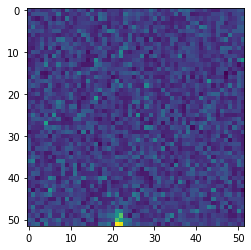

GroundTruth: gamma
tensor([0])


In [9]:
#Check the ground truth here on test_images
dataiter=iter(testloader)
images, labels=dataiter.next()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth:',' '.join('%5s'%classes[labels[j]]for j in range(1)))
print(labels)

In [10]:
#load back in our saved model
net=Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [11]:
##Test the network on the test data:#check if the network has learnt anything at all.
#check this by predicting the class label that the neural network outputs, and checking it
#against the ground-truth we got before:

#now let us see what the neural network thinks these examples above are:
outputs= m(net(images))
predicted = outputs > 0.5
print('Predicted:',' '.join(' %5s' % classes[predicted[j]] for j in range(1)))

Predicted:  gamma


In [12]:
#Let us look at how the network performs on the whole test_set
#For test_set of batch size 1
correct=0
total=0
test_y=[]
y_score=[]
with torch.no_grad():
    for data in testloader:
        images, labels=data
        outputs=m(net(images))
        #new_outputs=outputs.view(10)
        predicted=(outputs.data > 0.5)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
        y_score.append(outputs.numpy())
        test_y.append(labels)
        #print(images.shape)
        
y_score=np.vstack(y_score).flatten()
test_y=np.vstack(test_y).flatten()
print('Accuracy of the network on the test images:%d%%' %(100*correct/total))
#print(test_y)
#print(y_score[test_y==0])

Accuracy of the network on the test images:88%


In [13]:
#what are the classes that performed well, and the classes that did not perform well:
class_correct=list(0. for i in range(2))
class_total=list(0. for i in range(2))
with torch.no_grad():
    for data in testloader:
        images, labels=data
        outputs=m(net(images))
        predicted=outputs > 0.5
        c=(predicted==labels).squeeze()
        label=labels
        class_correct[label]+=c.item()
        class_total[label]+=1
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i],100*class_correct[i]/class_total[i]))
    #print(class_correct[0]/class_total[0])
    #print(i)
        

Accuracy of gamma : 98 %
Accuracy of proton : 78 %


In [14]:
outputs_proton_list = []
outputs_gamma_list = []
with torch.no_grad():
    #outputs = 0
    for data in testloader:
        images, labels=data
        outputs_proton=m(net(images))
        outputs_gamma = 1-outputs_proton
        predicted=outputs > 0.5
        c=(predicted==labels).squeeze()
        label=labels
        class_correct[label]+=c.item()
        class_total[label]+=1
        outputs_proton_list.append(outputs_proton)
        outputs_gamma_list.append(outputs_gamma)
#print(outputs_proton_list)
#print(outputs_gamma_list)
    
for i in range(2):
    print('Accuracy of %5s : %2d %%' % (classes[i],100*class_correct[i]/class_total[i]))

Accuracy of gamma : 48 %
Accuracy of proton : 92 %


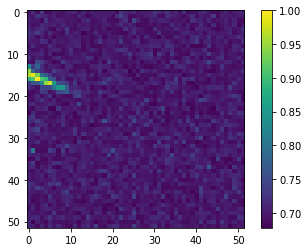

In [23]:
from matplotlib import colors
#cmap = plt.cm.get_cmap('viridis')
data, _ = train_set[1126]
plt.imshow(data)
plt.colorbar()
plt.show()

In [ ]:
##Visualize feature maps from first and second second conv layers:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
net.conv1.register_forward_hook(get_activation('conv1'))
data, _ = train_set[1126]
data.unsqueeze_(0)
output = net(data)
act = activation['conv1'].squeeze()
plt.figure(figsize=(10, 10))
for i, filter in enumerate(act):
    plt.subplot(4,4,i+1)
    plt.imshow(filter.detach())
    plt.axis('off')
    plt.colorbar()
plt.show()

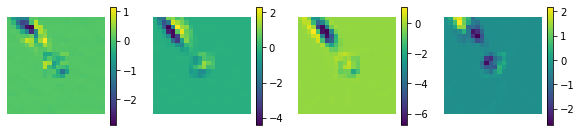

In [276]:
# Visualize feature maps from second convolutional layer(conv2)
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook
net.conv2.register_forward_hook(get_activation('conv2'))
data, _ = train_set[1126]
data.unsqueeze_(0)
output = net(data)
act = activation['conv2'].squeeze()
plt.figure(figsize=(10, 10))
for i, filter in enumerate(act):
    plt.subplot(4,4,i+1)
    plt.imshow(filter.detach())
    plt.axis('off')
    plt.colorbar()
plt.show()

In [460]:
#Confusion matrix when batchsize = 1
import numpy as np 
TP, FP, TN, FN = 0,0,0,0
treshold = 0.0
#for  threshold in np.arange(0.0, 1.0, 0.05):
for data, label in testloader: #with batchsize 1
    predict = m(net(data))
    predict_gamma = 1- predict
    predict_class = predict_gamma >= treshold
    if label == 1:  
        if predict_class == 1: #-------------------------------FP
            FP+=1
        elif predict_class == 0: #----------------TN-proton
            TN+=1

    elif label == 0:   
        if predict_class == 0: #--------------------------- FN
            FN+=1
        elif predict_class == 1: #-------------------TP-gamma
            TP+=1
            


print(TP)
print(FP)
print(FN)
print(TN)


2140
2540
0
0


In [14]:
##List the false predictions as image file names so that it can be added to the next network
import os 
import glob
def moving_protons(treshold):
    false_protons = glob.glob('./data/wholedata/without_noise/ring_noring/test_set/proton/*.npy')
    for name in false_protons:
        os.remove(str(name))
    sample_fname_list = []
    images_list = []
    test_y = []
    predict = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader, 0):
            outputs = m(net(images))
            outputs_gamma = 1-outputs
            #new_outputs = outputs.view(10)
            predicted = (outputs_gamma.data >= treshold)
            sample_fname, _ = testloader.dataset.samples[i]
            #print(sample_fname)
            predict.append((predicted.numpy().astype(int)))
            test_y.append(labels)
            images_list.append(images.numpy())
            sample_fname_list.append(sample_fname)
    predict = np.vstack(predict).flatten()
    test_y= np.vstack(test_y).flatten()
    images_list = np.vstack(images_list)
    sample_fname_list = np.asarray(sample_fname_list)

    false_predict_mask = ((predict == test_y) == True)
    #false_predict_mask = ((predict == test_y) == False)
    false_predict = predict[false_predict_mask]
    false_predict_img = images_list[false_predict_mask]
    false_predict_test_y = test_y[false_predict_mask]

    false_pred_True0_mask = (false_predict_test_y == 0)
    false_pred_True1_mask = (false_predict_test_y == 1)

    false_pred_True0_img = false_predict_img[false_pred_True0_mask]
    false_pred_True1_img = false_predict_img[false_pred_True1_mask]

    false_predict_sample_fname_list = sample_fname_list[false_predict_mask]
    #print(len(false_predict_sample_fname_list))

    false_pred_True0_sample_fname_list = false_predict_sample_fname_list[false_pred_True0_mask]
    false_pred_True1_sample_fname_list = false_predict_sample_fname_list[false_pred_True1_mask]
    #print(len(false_pred_True0_sample_fname_list))
    #print(len(false_pred_True1_sample_fname_list))
    #print(false_pred_True1_sample_fname_list)

    #for name in false_pred_True1_sample_fname_list:
    for name in false_pred_True1_sample_fname_list:
        os.system('cp '+str(name)+ ' ./data/wholedata/without_noise/ring_noring/test_set/proton/')
#print(false_pred_True1_sample_fname_list)

In [15]:
#print(len(false_pred_True0_sample_fname_list))
#print(len(false_pred_True1_sample_fname_list))

In [16]:
#moving_protons(0.95)

In [17]:
##List the True predictions as image file names (fo gamma) so that it can be added to the next network
def moving_gamma(treshold):
    false_gammas = glob.glob('./data/wholedata/without_noise/ring_noring/test_set/gamma/*.npy')
    for name in false_gammas:
        os.remove(str(name))
    sample_fname_list = []
    images_list = []
    test_y = []
    predict = []
    with torch.no_grad():
        for i, (images, labels) in enumerate(testloader, 0):
            outputs = m(net(images))
            outputs_gamma = 1-outputs
            #new_outputs = outputs.view(10)
            predicted = (outputs_gamma.data >= treshold)
            sample_fname, _ = testloader.dataset.samples[i]
            #print(sample_fname)
            predict.append((predicted.numpy().astype(int)))
            test_y.append(labels)
            images_list.append(images.numpy())
            sample_fname_list.append(sample_fname)
    predict = np.vstack(predict).flatten()
    test_y= np.vstack(test_y).flatten()
    images_list = np.vstack(images_list)
    sample_fname_list = np.asarray(sample_fname_list)

    true_predict_mask = ((predict == test_y) == False)
    #true_predict_mask = ((predict == test_y) == True)
    true_predict = predict[true_predict_mask]
    true_predict_img = images_list[true_predict_mask]
    true_predict_test_y = test_y[true_predict_mask]

    true_pred_True0_mask = (true_predict_test_y == 0)
    true_pred_True1_mask = (true_predict_test_y == 1)

    true_pred_True0_img = true_predict_img[true_pred_True0_mask]
    true_pred_True1_img = true_predict_img[true_pred_True1_mask]

    true_predict_sample_fname_list = sample_fname_list[true_predict_mask]


    true_pred_True0_sample_fname_list = true_predict_sample_fname_list[true_pred_True0_mask]
    true_pred_True1_sample_fname_list = true_predict_sample_fname_list[true_pred_True1_mask]
    #print(len(true_pred_True0_sample_fname_list))
    #print(len(true_pred_True1_sample_fname_list))
    #print(true_pred_True0_sample_fname_list)
    #for name in true_pred_True0_sample_fname_list:
    for name in true_pred_True0_sample_fname_list:
        os.system('cp '+str(name)+ ' ./data/wholedata/without_noise/ring_noring/test_set/gamma/')
                #print(false_pred_True1_sample_fname_list)

In [22]:
#moving_gamma(0.95)

In [23]:
#print(len(true_pred_True0_sample_fname_list))
#print(len(true_pred_True1_sample_fname_list))

In [24]:
##define ring-noring network here
class Net_ring_wholedata(nn.Module):
    def __init__(self):
        super(Net_ring_wholedata,self).__init__()
        self.conv1=nn.Conv2d(1,20,5)
        self.pool=nn.MaxPool2d(2,2)
        self.conv2=nn.Conv2d(20,4,3)
        self.fc1=nn.Linear(4*11*11,80)
        self.fc2=nn.Linear(80,1)
    def forward(self, x):
        x=x.view(-1,1,52,52)
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        x=x.view(-1,4*11*11)
        x=F.relu(self.fc1(x))
        x=self.fc2(x)
        return x
net_ring_wholedata=Net_ring_wholedata()

In [40]:
###merge two networks:
##List the false predictions as image file names so that it can be added to the next network
import os 
import glob


tresholds = np.arange(0.0, 1, 0.05)
TP_list, FP_list, TN_list, FN_list = [],[],[],[]
#Q_factor_list = []
#gamma_efficiency_list= []
#proton_efficiency_list = []

#get the total number of gammas and protons in the test set of first network(gamma-proton) 
#to calculate the Q factor

total_gammas = len(glob.glob('./data/wholedata/without_noise/gamma_proton/test_set/gamma/*.npy'))
total_protons = len(glob.glob('./data/wholedata/without_noise/gamma_proton/test_set/proton/*.npy'))

##save our ring-noring trained model

PATH_ring_wholedata='./wholedata/ring_noring/ring_noring_without_noise.pth'#-----without block

for treshold in tresholds:
    moving_protons(treshold)
    moving_gamma(treshold)
    test_set_ring_wholedata = torchvision.datasets.DatasetFolder(root='./data/wholedata/without_noise/ring_noring/test_set/',
                                                  loader=npy_loader, 
                                                   extensions='.npy', transform=None)
    #test_set_ring_wholedata = torchvision.datasets.DatasetFolder(root='./data/ring_noring_23-02-2021/test_set/',
    #                                              loader=npy_loader, 
    #                                               extensions='.npy', transform=None)

    testloader_ring_wholedata = torch.utils.data.DataLoader(test_set_ring_wholedata, batch_size=1,
                                             shuffle=False, num_workers=2)

    #torch.save(net.state_dict(), PATH)
    #load back in our ring-noring model
    
    net_ring_wholedata=Net_ring_wholedata()
    net_ring_wholedata.load_state_dict(torch.load(PATH_ring_wholedata))

    ##calculate confusion matrix from the ring-noring network
    #for  threshold in np.arange(0.0, 1.0, 0.05):
    
    TP, FP, FN, TN = 0, 0, 0, 0
    for data, label in testloader_ring_wholedata: #with batchsize 1
        predict = m(net_ring_wholedata(data))
        predict_gamma = 1-predict
        predict_class = predict_gamma >= treshold
        #predict_class = predict > treshold
        #print(label)
        if label == 1:  
            if predict_class == 1:  #-------------------------------FP
                FP+=1
            elif predict_class == 0: #-------------------------------TN-proton
                TN+=1

        elif label == 0:   
            if predict_class == 0: #-----------------------------FN
                FN+=1
            elif predict_class == 1: #--------------------TP-gamma
                TP+=1
    #print(TN)
    #print(FP)
    TP_list.append(TP)
    FP_list.append(FN)
    TN_list.append(TN)
    FN_list.append(FP)
    

###Qfactor from the second network. In our case, there are 2. So have to consider the confusion matrix from 
#the second network too
    #print(TP)
    #print(total_gammas)
    #TP_array = np.array(TP_list)
    #FN_array = np.array(FP_list)
    #TN_array = np.array(TN_list)
    #FP_array = np.array(FP_list)
    
    #gamma_efficiency = TP_list/(total_gammas)
    #gamma_efficiency = TP_array/(total_gammas)
    #proton_efficiency = FP_list/(total_protons)
    #proton_efficiency = FN_array/(total_protons)
    #gamma_efficiency_list.append(gamma_efficiency)
    #proton_efficiency_list.append(proton_efficiency)
    #Q_factor = gamma_efficiency/(np.sqrt(proton_efficiency))
    #Q_factor_list.append(Q_factor)
    

print(TP_list)
print(FP_list)
print(FN_list)
print(TN_list)
#print(gamma_efficiency_list)
#print(proton_efficiency_list)
#print(Q_factor_list)
#print(FN_list)
#print(TN_list)
#print(total_gammas)
#print(total_protons)

[2140, 2103, 2089, 2083, 2076, 2066, 2051, 2038, 2025, 2005, 1986, 1962, 1927, 1826, 1761, 1690, 1620, 1520, 1396, 1246]
[0, 21, 31, 32, 36, 40, 42, 43, 49, 55, 62, 72, 81, 94, 113, 138, 169, 212, 249, 280]
[2540, 686, 624, 584, 552, 519, 490, 466, 433, 407, 382, 346, 299, 215, 181, 144, 123, 94, 65, 46]
[0, 57, 54, 55, 57, 54, 53, 57, 59, 58, 56, 63, 61, 54, 58, 63, 59, 60, 59, 49]


In [43]:
TP_array = np.array(TP_list)
FP_array = np.array(FP_list)
FN_array = np.array(FN_list)
TN_array = np.array(TN_list)
#print(TP_array)
#print(FN_array)
gamma_efficiency_list = TP_array/(total_gammas)
proton_efficiency_list = FN_array/(total_protons)
Q_factor_list = gamma_efficiency_list/(np.sqrt(proton_efficiency_list))
print(gamma_efficiency_list)
print(proton_efficiency_list)
print(Q_factor_list)
#print(tresholds)
#print(gamma_efficiency_list)
#print(proton_efficiency_list)
#print(Q_factor_list)
#print(len(gamma_efficiency_list))
#print(len(proton_efficiency_list))

[1.         0.98271028 0.97616822 0.97336449 0.97009346 0.96542056
 0.95841121 0.95233645 0.94626168 0.93691589 0.92803738 0.91682243
 0.90046729 0.85327103 0.8228972  0.78971963 0.75700935 0.71028037
 0.65233645 0.58224299]
[1.         0.27007874 0.24566929 0.22992126 0.21732283 0.20433071
 0.19291339 0.18346457 0.17047244 0.16023622 0.1503937  0.13622047
 0.11771654 0.08464567 0.07125984 0.05669291 0.0484252  0.03700787
 0.02559055 0.01811024]
[1.         1.89095111 1.96946937 2.02995276 2.08094641 2.1357466
 2.18208018 2.22338313 2.29183931 2.34056258 2.3930438  2.48407119
 2.62451588 2.93281473 3.08264244 3.31671797 3.44005625 3.69217899
 4.07785543 4.32655483]


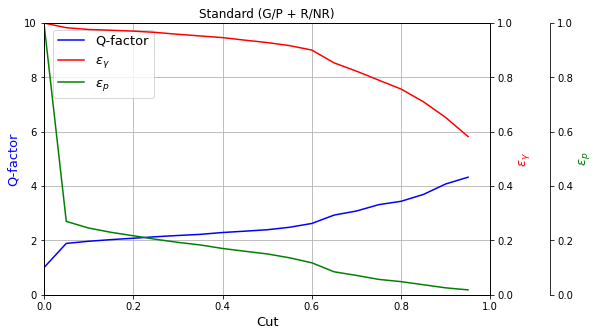

In [44]:
##plotting Q-factor vs cut
#Here onwards, Itake the Q factor from both the network(which I do manually) and plot it here as a 
#function of cut for different noise levels
#For noise level: 4.5 pe

#print(cut)
#print(Q)
#print(eps_gamma)
#print(eps_proton)
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0.0, 1)
host.set_ylim(0, 10)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

#p1, = host.plot(cut, Q, color='blue', label="Q-factor")
#p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
#p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

p1, = host.plot(tresholds, Q_factor_list, color='blue', label="Q-factor")
p2, = par1.plot(tresholds, gamma_efficiency_list, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(tresholds, proton_efficiency_list, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best', bbox_to_anchor=(0.01, 0.5, 0.25, 0.5), fontsize=13)

plt.title('Standard (G/P + R/NR)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
host.grid()
# Best for professional typesetting, e.g. LaTeX
#plt.savefig("train_test_blackout_july_22.png", bbox_inches='tight')
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'


In [459]:
#pred
#for data_new, label_new in testloader: #with batchsize 1
#        predict_new = m(net(data_new))
#        predict_list_new.append(predict_new)

In [18]:
##Q-factor calculation from single network: gamma/proton
import os 
import glob

tresholds_new = np.arange(0.0, 1, 0.01)
TP_list_new, FP_list_new, TN_list_new, FN_list_new = [],[],[],[]
Q_factor_list_new = []
gamma_efficiency_list_new= []
proton_efficiency_list_new = []

#get the total number of gammas and protons in the test set of first network(gamma-proton) to calculate the Q factor
total_gammas_new = len(glob.glob('./data/wholedata/without_noise/gamma_proton/test_set/gamma/*.npy'))
total_protons_new = len(glob.glob('./data/wholedata/without_noise/gamma_proton/test_set/proton/*.npy'))

for treshold_new in tresholds_new:
    ##calculate confusion matrix from the ring-noring network
   
    TP_new, FP_new, FN_new, TN_new = 0, 0, 0, 0
    for data_new, label_new in testloader: #with batchsize 1
        predict_new = m(net(data_new))
        predict_new_gamma = 1-predict_new
        predict_class_new = predict_new_gamma >= treshold_new #< treshold_new
        #predict_class_new = predict_new >= treshold_new
        if label_new == 1:  
            if predict_class_new == 1: #-------------------------------FP
                FP_new+=1
            elif predict_class_new == 0: #----------------------------TN-proton
                TN_new+=1

        elif label_new == 0:   
            if predict_class_new == 0: #-----------------------------FN
                FN_new+=1
            elif predict_class_new == 1: #------------------------TP-gamma
                TP_new+=1 
    
    TP_list_new.append(TP_new)
    FP_list_new.append(FN_new)
    TN_list_new.append(TN_new)
    FN_list_new.append(FP_new)
    

    ###Qfactor from a single network. In our case, there is 2. So have to consider the confusion matrix 
    ###from the second network too
    gamma_efficiency_new = TP_new/(total_gammas_new)#TP_new/(total_gammas_new)
    proton_efficiency_new = FP_new/(total_protons_new)#FN_new/(total_protons_new)
    gamma_efficiency_list_new.append(gamma_efficiency_new)
    proton_efficiency_list_new.append(proton_efficiency_new)
    Q_factor_new = gamma_efficiency_new/(np.sqrt(proton_efficiency_new))
    Q_factor_list_new.append(Q_factor_new)
print(TP_list_new)    
#print(TP_list_new)
#print(FP_list_new)
#print(FN_list_new)
#print(TN_list_new)
print(total_gammas_new)
#print(total_protons_new)

[2140, 2136, 2135, 2135, 2134, 2134, 2134, 2134, 2134, 2134, 2134, 2134, 2134, 2134, 2134, 2133, 2133, 2133, 2133, 2133, 2132, 2132, 2131, 2131, 2131, 2131, 2131, 2131, 2131, 2129, 2128, 2128, 2127, 2127, 2127, 2127, 2127, 2126, 2124, 2122, 2122, 2122, 2121, 2121, 2119, 2117, 2117, 2117, 2116, 2114, 2114, 2114, 2112, 2111, 2111, 2111, 2108, 2105, 2103, 2098, 2095, 2086, 2080, 2073, 2067, 2055, 2045, 2032, 2022, 2016, 2000, 1985, 1968, 1954, 1938, 1910, 1860, 1808, 1747, 1684, 1638, 1590, 1548, 1527, 1508, 1487, 1461, 1435, 1402, 1367, 1328, 1295, 1247, 1184, 1104, 1027, 927, 804, 713, 565]
2140


In [19]:
print(Q_factor_list_new)
print(gamma_efficiency_list_new)
print(proton_efficiency_list_new)
print(len(Q_factor_list_new))
print(len(gamma_efficiency_list_new))
print(len(proton_efficiency_list_new))

[1.0, 1.4694016645342658, 1.5243563935269517, 1.5636541252357679, 1.5908609786722556, 1.6178335722558925, 1.634863868628584, 1.656028035922151, 1.672451856314241, 1.684622111513814, 1.6980303443712044, 1.707806074791185, 1.7248195058111917, 1.7330037487120697, 1.7455015338090372, 1.7639388005271284, 1.7760244771033293, 1.79063295994044, 1.8032796420103063, 1.817386347014387, 1.8225078070192164, 1.82854061996586, 1.8362264282406233, 1.8424027875182707, 1.851155344087887, 1.86387821096125, 1.8755559471286398, 1.883464159071415, 1.9023127331444345, 1.9101573127763436, 1.9204418108326733, 1.9332591398154346, 1.9527993778992576, 1.9647798545670012, 1.969329717520833, 1.9739113360842908, 1.9816189457893876, 1.9884822388133607, 1.9960792292572103, 2.0070242493839134, 2.0135300176593245, 2.021751897584569, 2.0341599408574824, 2.0477893056457015, 2.0597522742352528, 2.0791700979537113, 2.0846153366926656, 2.095635406449682, 2.1191230855228103, 2.130648195469549, 2.1524406082920873, 2.1687163834

In [20]:
np.array(FP_list_new)[tresholds_new==0.87]/total_protons_new

array([0.27755906])

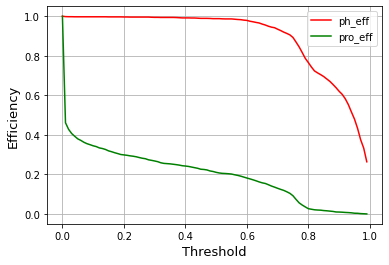

In [21]:
##photon efficiencies vs cut:
plt.plot(tresholds_new, gamma_efficiency_list_new, color='red', label="ph_eff")
##proton efficiency vs cut
plt.plot(tresholds_new, proton_efficiency_list_new, color='green', label='pro_eff')
plt.legend(loc='best')
plt.xlabel("Threshold", fontsize=13)
plt.ylabel("Efficiency", fontsize=13)
plt.grid()

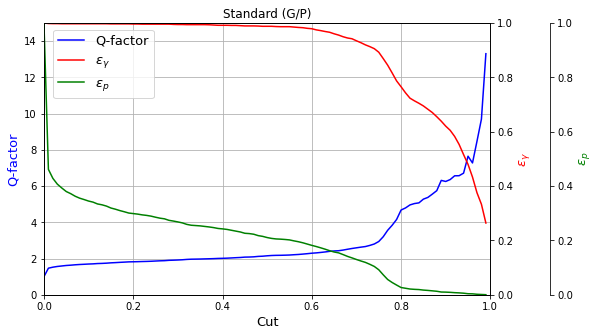

In [23]:
##plotting Q-factor vs cut
# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0.0, 1)
host.set_ylim(0, 15)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut", fontsize=13)
host.set_ylabel("Q-factor", fontsize=13)
par1.set_ylabel('$\epsilon_{\gamma}$', fontsize=13)
par2.set_ylabel("$\epsilon_{p}$", fontsize=13)

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

#p1, = host.plot(cut, Q, color='blue', label="Q-factor")
#p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
#p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

p1, = host.plot(tresholds_new, Q_factor_list_new, color='blue', label="Q-factor")
p2, = par1.plot(tresholds_new, gamma_efficiency_list_new, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(tresholds_new, proton_efficiency_list_new, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best', bbox_to_anchor=(0.01, 0.5, 0.25, 0.5), fontsize=13)

plt.title('Standard (G/P)')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

#tval = 0.87
#host.axvline(tval, color='k', label=f'{tval}')
#host.legend(loc='best')

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())
host.grid()
# Best for professional typesetting, e.g. LaTeX
#plt.savefig("train_test_blackout_july_22.png", bbox_inches='tight')
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'


In [118]:
tresholds = np.arange(0,1,0.05)
Q_factor_list = [0]+Q_factor_list
gamma_efficiency_list= [0]+gamma_efficiency_list
proton_efficiency_list = [0]+proton_efficiency_list
cut = tresholds
Q =  Q_factor_list
eps_gamma = gamma_efficiency_list
eps_proton = proton_efficiency_list

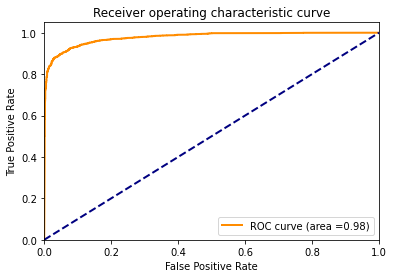

In [151]:
# Compute ROC curve and ROC area for each class
#test_y = labels
#y_score = predicted
#Here threashold is fixed which is equal to 0.5

from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score

fpr, tpr, thresholds = metrics.roc_curve(test_y, y_score)
roc_auc = auc(fpr, tpr)
plt.figure()
lw=2
plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve (area =%0.2f)'%roc_auc)
plt.plot([0,1], [0,1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()
#print(thresholds)

In [ ]:
#Confusion matrix when batchsize = 10
import numpy as np 
TP, FP, TN, FN = 0,0,0,0
treshold = 0.95
test_y=[]
y_score=[]
predict_class = []
with torch.no_grad():
    for data in testloader:
        images_test, labels_test=data
        outputs_test=m(net(images_test))
        new_outputs=outputs_test.view(10)
        predicted=(new_outputs.data > treshold)
        predicted_new = predicted.view(10)
        predict_class.append(predicted_new)
        y_score.append(new_outputs.numpy())
        test_y.append(labels_test)
y_score=np.vstack(y_score).flatten()
test_y=np.vstack(test_y).flatten()
predict_class = np.vstack(test_y).flatten()
if test_y.all() == 1:  #-------------------------------Negitive-proton
    if predict_class.all() == 1:
        TN+=1
    elif predict_class.all() == 0:
        FP+=1

elif test_y.all() == 0:   #-----------------------------Positive-gamma
    if predict_class.all() == 0:
        TP+=1
    elif predict_class.all() == 1:
        FN+=1



print(TP)
print(FP)
print(FN)
print(TN)
#print(predict_class)

In [ ]:
##list the false predicted data as images
images_list = []
test_y = []
predict = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = m(net(images))
        new_outputs = outputs.view(10)
        predicted = (new_outputs.data > 0.5)

        predict.append((predicted.numpy().astype(int)))
        test_y.append(labels)
        images_list.append(images.numpy())

predict = np.vstack(predict).flatten()
test_y= np.vstack(test_y).flatten()
images_list = np.vstack(images_list)

false_predict_mask = ((predict == test_y) == False)
false_predict = predict[false_predict_mask]
false_predict_img = images_list[false_predict_mask]
false_predict_test_y = test_y[false_predict_mask]

false_pred_True0_mask = (false_predict_test_y == 0)
false_pred_True1_mask = (false_predict_test_y == 1)

false_pred_True0_img = false_predict_img[false_pred_True0_mask]
false_pred_True1_img = false_predict_img[false_pred_True1_mask]

#print(false_pred_True0_img.shape)
#print(false_pred_True1_img.shape)


##To get FP/FN as images:

def imshow_np(img):
    print(img.shape)
    print(img[0].shape)
    plt.imshow(img[0])
    print(np.max(img))
    plt.show()

for i in range(false_pred_True1_img.shape[0]):
    imshow_np(false_pred_True1_img[i:i+1])
    #plt.savefig('./{0:s}.png'.format(filename))#, np.c_data)

In [ ]:
#Calculating the confusion matrix(2*2): TP,TN,FP,FN using a package called sklearn(default threashold= 0.5)
#print(metrics.confusion_matrix(test_y, y_score.round()))
from sklearn.metrics import roc_curve
import sklearn.metrics as metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score
confusion=metrics.confusion_matrix(test_y, y_score.round())
print(confusion)
#[row, column]
TP=confusion1[0,0]
TN=confusion1[1,1]
FN=confusion1[1,0]
FP=confusion1[0,1]
#print(test_y)
#print(y_score)

<ipython-input-251-e03cc8908aa2>:4: MatplotlibDeprecationWarning: The 'nonposy' parameter of __init__() has been renamed 'nonpositive' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', nonposy='clip')


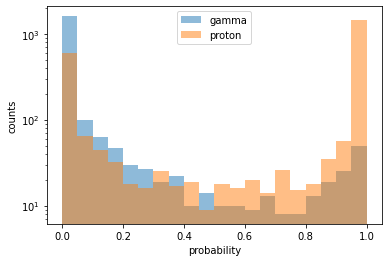

2100
2500


In [251]:
#Histogram showing the gamm and proton predictions from the network
plt.hist(y_score[test_y==0], bins=20, alpha=0.5, label='gamma')
plt.hist(y_score[test_y==1], bins=20, alpha=0.5, label='proton')
plt.yscale('log', nonposy='clip')
plt.xlabel('probability')
plt.ylabel('counts')
plt.legend(loc='best')
plt.show()
print(len(y_score[test_y==0]))
print(len(y_score[test_y==1]))

In [ ]:
#Qfactor from a single network. In our case, there is 2. So have to consider the confusion matrix 
#from the second network too
gamma_efficiency = (class_correct[0]/class_total[0])
proton_efficiency = (FN/TP)
Q_factor = gamma_efficiency/(np.sqrt(proton_efficiency))
#print(gamma_efficiency)
print(Q_factor)

In [ ]:
#Here onwards, Itake the Q factor from both the network(which I do manually) and plot it here as a 
#function of cut for different noise levels
#For noise level: 4.5 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
Q =   [0, 26.33, 27.3, 27.66, 21.25, 29.33, 22.25, 29.66, 22.4, 15.16, 15.16, 15.16, 15.5, 11.03, 10.77, 9.7, 9.7, 9.7, 7, 5.7]
eps_gamma = [0.0, 0.79, 0.82, 0.83,  0.85, 0.88, 0.89, 0.89, 0.90, 0.91, 0.91, 0.91, 0.93, 0.96, 0.97, 0.97, 0.97, 0.97, 0.98, 0.98]
eps_proton = [0.0, 0.00097, 0.00097, 0.00097, 0.0019, 0.00097, 0.0019, 0.00097, 0.0019, 0.0038, 0.0038, 0.004, 0.0038, 0.0077, 0.0087, 0.01, 0.01, 0.01, 0.022, 0.03]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level: 4.5 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
#For noise level: 9 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

eps_gamma = [0.0, 0.78, 0.82, 0.85, 0.87, 0.87, 0.88, 0.88, 0.88, 0.89, 0.90, 0.91, 0.92, 0.92, 0.92, 0.94, 0.95, 0.96, 0.96, 0.97]
eps_proton = [0.0, 0.00097, 0.00097, 0.0019, 0.00097, 0.00097, 0.0029, 0.0058, 0.003, 0.01, 0.0077, 0.01, 0.0077, 0.0087, 0.0067, 0.01, 0.03, 0.01, 0.01, 0.03]
Q =   [0.0, 26.15, 27.33, 21.25, 29, 29, 17.6, 12.57, 17.6, 8.9, 11.25, 8.34, 11.5, 9.86, 11.5, 9.4, 5.4, 9.6, 9.6, 5.6]

# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level: 9 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
plt.savefig("9pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
#For noise level: 20 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

eps_gamma = [0.0, 0.77, 0.81, 0.84, 0.85, 0.85, 0.86, 0.87, 0.87, 0.88, 0.89, 0.90, 0.91, 0.91, 0.92, 0.92, 0.94, 0.95, 0.96, 0.96]
eps_proton = [0.0, 0.00097, 0.0029, 0.00097, 0.0019, 0.0048, 0.0029, 0.0029, 0.0038, 0.0087, 0.0067, 0.0048, 0.0058, 0.0087, 0.0058, 0.0048, 0.011, 0.01, 0.01, 0.03]
Q =   [0.0, 25, 16.2, 28, 19.5, 13.4, 15.96, 16.15, 14.11, 9.4, 10.87, 12.99, 11.94, 9.7, 12.08, 13.27, 8.96, 9.5, 9.6, 5.54]

# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level: 20 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
plt.savefig("20pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
#For noise level: 40 p e
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

eps_gamma = [0.0, 0.82, 0.84, 0.86, 0.87, 0.88, 0.88, 0.89, 0.89, 0.89, 0.90, 0.92, 0.92, 0.93, 0.94, 0.94, 0.96, 0.97, 0.98, 0.99]
eps_proton = [0.0, 0.0058, 0.0087, 0.01, 0.01, 0.01, 0.01, 0.02, 0.01, 0.02, 0.02, 0.03, 0.03, 0.03, 0.04, 0.04, 0.05, 0.05, 0.06, 0.08]
Q =   [0.0, 10.78, 9.33, 8.6, 8.7, 8.8, 8.8, 6.35, 8.9, 6.35, 6.4, 5.4, 5.4, 5.47, 4.7, 4.7, 4.3, 4.4, 4.08, 3.5]

# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level: 40 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
plt.savefig("40pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
print(len(y_score))

In [ ]:
np.savetxt('./data/adding_noisy_test_data/y_score_gamma_proton.txt', y_score, fmt='%1.4e')

In [ ]:
TP, FP, TN, FN = 0,0,0,0
treshold = 0.5
#for threshold in range(0, 1, 0.5):
for data, label in testloader: #with batchsize 1
    predict = m(net(data))
    #new_predict = predict.view(10)
    predict_class = predict > treshold
    #print(label)
    if label == 1:
        if predict_class == 1:
            TP+=1
        elif predict_class == 0:
            FN+=1

    elif label == 0:
        if predict_class == 0:
            TN+=1
        elif predict_class == 1:
            FP+=1
print(TP)
print(FP)
print(TN)
print(FN)

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 4.5 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.0, 0.64, 0.72, 0.70, 0.71, 0.72, 0.72, 0.78, 0.79, 0.80, 0.82, 0.82, 0.83, 0.84, 0.84, 0.85, 0.86, 0.87, 0.88, 0.90]
eps_proton = [0.0, 0.00097, 0.00097, 0.00097, 0.0019, 0.0019, 0.0029, 0.0029, 0.0038, 0.0058, 0.0058, 0.0058, 0.0067, 0.0067, 0.0077, 0.0077, 0.01, 0.017, 0.020, 0.03]
Q =   [0.0, 21.33, 24, 23.33, 17.75, 18, 14.4, 15.6, 13.16, 11.4, 11.73, 11.82, 10.24, 10.38, 9.65, 9.81, 8.6, 6.69, 6.28, 5.29]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level (10 scattered blackout pixels): 4.5 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
##After adding 10 block of blackout pixels 
#For noise level: 4.5 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.0, 0.8, 0.77, 0.78, 0.79, 0.80, 0.81, 0.82, 0.83, 0.84, 0.84, 0.85, 0.85, 0.86, 0.86,  0.86, 0.87, 0.87, 0.87, 0.88]
eps_proton = [0.0, 0.02, 0.02, 0.02, 0.02, 0.025, 0.026, 0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.037, 0.04, 0.04, 0.04, 0.04, 0.05, 0.06]
Q =   [0.0, 5.7, 5.52, 5.57, 5.64, 5.33, 5.06, 4.82, 4.88, 4.94, 4.94, 5, 5, 5.05, 4.3, 4.3, 4.35, 4.35, 3.95, 3.66]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level (10 block of blackout pixels): 4.5 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 9 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.09, 0.86, 0.87, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.90, 0.91, 0.91, 0.92, 0.93, 0.94, 0.94, 0.95, 0.95, 0.96, 0.96]
eps_proton = [0.01, 0.49, 0.51, 0.52, 0.52, 0.52, 0.52, 0.53, 0.54, 0.55, 0.55, 0.56, 0.57, 0.58, 0.59, 0.60, 0.60, 0.62, 0.63, 0.65]
Q =   [0.9, 1.75, 1.22, 1.22, 1.22, 1.22, 1.23, 1.23, 1.21, 1.21, 1.22, 1.22, 1.22, 1.22, 1.23, 1.22, 1.23, 1.21, 1.21, 1.2]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level (10 scattered blackout pixels): 9 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
##After adding 10 block of blackout pixels 
#For noise level: 9 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.006, 0.89, 0.90, 0.91, 0.91, 0.92, 0.92, 0.93, 0.93, 0.93, 0.93, 0.94, 0.94, 0.94, 0.94, 0.94, 0.95, 0.95, 0.95, 0.96]
eps_proton = [0.0019, 0.50, 0.53, 0.54, 0.55, 0.56, 0.57, 0.57, 0.58, 0.57, 0.58, 0.59, 0.59, 0.59, 0.60, 0.61, 0.61, 0.62, 0.63, 0.64]
Q =   [0.15, 1.27, 1.25, 1.24, 1.22, 1.24, 1.22, 1.24, 1.22, 1.24, 1.22, 1.23, 1.34, 1.23, 1.22, 1.20, 1.21, 1.21, 1.20, 1.2]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level (10 block of blackout pixels): 9 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
##After adding scattered 10 blackout pixels 
#For noise level: 20 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.0, 0.62, 0.68, 0.70, 0.71, 0.75, 0.75, 0.77, 0.78, 0.78, 0.80, 0.81, 0.81, 0.82, 0.82,  0.82, 0.83, 0.84, 0.85, 0.87]
eps_proton = [0.0,0.0019, 0.0029, 0.0038, 0.0038, 0.0058, 0.0058, 0.0077, 0.0087, 0.0097, 0.0097, 0.01, 0.01, 0.01, 0.017, 0.01, 0.019, 0.021, 0.027, 0.037]
Q =   [0.0, 15.5, 13.6, 11.66, 11.83, 10.71, 10.71, 9.62, 8.66, 7.95, 8.16, 8.1, 8.1,8.2, 6.38, 6.38, 6.38, 6, 5.3, 4.57]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 0.1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level (10 scattered blackout pixels): 20 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
##After adding 10 block of blackout pixels 
#For noise level: 20 pe
cut = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
eps_gamma = [0.0, 0.82, 0.86, 0.87, 0.87, 0.88, 0.88, 0.88, 0.88, 0.88, 0.89, 0.89, 0.89, 0.90, 0.91, 0.91, 0.92, 0.92, 0.93, 0.94]
eps_proton = [0.0, 0.27, 0.29, 0.29, 0.30, 0.30, 0.31, 0.31, 0.31, 0.32, 0.32, 0.33, 0.33, 0.34, 0.34, 0.35, 0.36, 0.37, 0.38, 0.40]
Q =   [0.0, 1.60, 1.62, 1.64, 1.61, 1.62, 1.6, 1.6, 1.6, 1.57, 1.58, 1.56, 1.56, 1.55, 1.56, 1.53, 1.53, 1.51, 1.50, 1.48]
# Create figure and subplot manually
# fig = plt.figure()
# host = fig.add_subplot(111)

# More versatile wrapper
fig, host = plt.subplots(figsize=(8,5)) # (width, height) in inches
# (see https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html)
    
par1 = host.twinx()
par2 = host.twinx()
    
host.set_xlim(0, 1)
host.set_ylim(0, 30)
par1.set_ylim(0, 1)
par2.set_ylim(0, 1)
    
host.set_xlabel("Cut")
host.set_ylabel("Q-factor")
par1.set_ylabel('$\epsilon_{\gamma}$')
par2.set_ylabel("$\epsilon_{p}$")

#color1 = plt.cm.viridis(0)
#color2 = plt.cm.viridis(0.5)
#color3 = plt.cm.viridis(.9)

p1, = host.plot(cut, Q, color='blue', label="Q-factor")
p2, = par1.plot(cut, eps_gamma, color='red', label=r'$\epsilon_{\gamma}$')
p3, = par2.plot(cut, eps_proton, color='green', label=r'$\epsilon_{p}$')

lns = [p1, p2, p3]
host.legend(handles=lns, loc='best')

plt.title('For noise level (10 block of blackout pixels): 20 p.e')
# right, left, top, bottom
par2.spines['right'].set_position(('outward', 60))

host.yaxis.label.set_color(p1.get_color())
par1.yaxis.label.set_color(p2.get_color())
par2.yaxis.label.set_color(p3.get_color())

# Best for professional typesetting, e.g. LaTeX
#plt.savefig("4.5pe_noise.pdf")
# For raster graphics use the dpi argument. E.g. '[...].png", dpi=200)'
print(np.max(Q))
print(np.max(eps_gamma))
print(np.max(eps_proton))

In [ ]:
import glob
m1 = nn.Dropout(p=0.0037)
#filenames = glob.glob('./data/dropout_function_4.5pe_training/gamma_proton/test_set/gamma/*.npy')
for data, label in testloader: #with batchsize 1
    output = m1(data)
    #print(len(output))
    #plt.imshow(data)

In [ ]:
m1 = nn.Dropout(p=0.0037)
dataiter=iter(testloader)
images, labels=dataiter.next()
images1 = m1(images)
#print(images1)
imshow(torchvision.utils.make_grid(images1))
#print('GroundTruth:',' '.join('%5s'%classes[labels[j]]for j in range(1)))
#print(labels)

In [ ]:
m1 = nn.Dropout(p=0.41)